##EfficientNet B0 Transfer Learning, Focal Loss, Knowledge Distillation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import copy
import time
import random
import numpy as np
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import datasets, models
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
seed = 1024
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
!pip install efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=026a9f3f1403dc9828a2b9a4e2ff17553a2853843709946e1884508e7a5a6fa1
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [ ]:
from efficientnet_pytorch import EfficientNet

###Load Data

In [ ]:
data_dir = '/content/drive/MyDrive/dlproject/data/output/'

train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'val/')
test_dir = os.path.join(data_dir, 'test/')

classes = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']
image_size = (224, 224)
batch_size = 64
num_workers = 2

In [ ]:
normalize = transforms.Normalize(mean=[0.4907, 0.4907, 0.4908],
                                 std=[0.2219, 0.2219, 0.2219])

image_transforms = {
    "train": transforms.Compose([transforms.Resize(image_size),  
                                 transforms.ToTensor(),
                                 normalize]),

    "val": transforms.Compose([transforms.Resize(image_size), 
                                transforms.ToTensor(), 
                                normalize]),

    "test": transforms.Compose([transforms.Resize(image_size), 
                                transforms.ToTensor(), 
                                normalize])
}

image_datasets = {
    "train": datasets.ImageFolder(train_dir, image_transforms["train"]),
    "val": datasets.ImageFolder(val_dir, image_transforms["val"]),
    "test": datasets.ImageFolder(test_dir, image_transforms["test"])
}

image_loaders = {
    "train": DataLoader(image_datasets["train"], 
                        shuffle=True, 
                        batch_size=batch_size, 
                        num_workers=num_workers),
    "val": DataLoader(image_datasets["val"], 
                      shuffle=True, 
                      batch_size=batch_size, 
                      num_workers=num_workers),
    "test": DataLoader(image_datasets["test"], 
                       shuffle=False, 
                       batch_size=batch_size, 
                       num_workers=num_workers)
}

dataset_sizes = {k: len(image_datasets[k]) for k in image_datasets}

###Build and Train Model

In [ ]:
def train(model, criterion, optimizer, n_epochs, patience, scheduler=None):
    hist = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
    not_improved = 0
    best_weights = None
    val_loss_min = np.Inf

    for epoch in range(n_epochs):
        epoch_stats = []
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            if phase == 'val':
                model.eval()
            losses = 0.0
            corrects = 0
            for data, target in image_loaders[phase]:
                data = data.cuda()
                target = target.cuda()

                out = model(data)
                loss = criterion(out, target)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(out, dim=-1)
                losses += loss.item() * data.size(0)
                corrects += torch.sum(preds==target.data).item()

            if phase == 'train' and scheduler:
                scheduler.step()
            
            epoch_stats += [losses / dataset_sizes[phase],
                            corrects / dataset_sizes[phase]]

        train_loss, train_acc, val_loss, val_acc = epoch_stats
        print('Epoch: {}\tloss: {:.6f}\taccuracy: {:.6f}\tval_loss: {:.6f}\tval_accuracy: {:.6f}'
              .format(epoch+1, train_loss, train_acc, val_loss, val_acc))
        
        if val_loss < val_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(val_loss_min, val_loss))
            best_weights = copy.deepcopy(model.state_dict())
            val_loss_min = val_loss
            not_improved = 0
        else:
            not_improved += 1
            if not_improved == patience and epoch < n_epochs-1:
                print('Early stopping ...')
                break
        
        model.load_state_dict(best_weights)
        hist['loss'] += [train_loss]
        hist['acc'] += [train_acc]
        hist['val_loss'] += [val_loss]
        hist['val_acc'] += [val_acc]
    return model, hist


def test(model, criterion):
    losses = 0.0
    corrects = 0
    num_class = 4
    cm = torch.zeros(num_class, num_class)

    model.eval()
    with torch.no_grad():
        for data, target in image_loaders["test"]:
            data = data.cuda()
            target = target.cuda()

            out = model(data)
            loss = criterion(out, target)

            # update confusion matrix
            _, preds = torch.max(out, dim=-1)
            for t, p in zip(target.view(-1), preds.view(-1)):
                cm[t.long(), p.long()] += 1
            losses += loss.item() * data.size(0)
            corrects += torch.sum(preds==target.data).item()

    test_loss = losses / dataset_sizes["test"]
    test_acc = corrects / dataset_sizes["test"]
    print("Test loss:", test_loss)
    print("Test accuracy:", test_acc)
    cm_percent = cm / cm.sum(1)
    per_cls_acc = cm_percent.diag().detach().numpy().tolist()
    for i, acc_i in enumerate(per_cls_acc):
        print("Test accuracy of class {}: {:.4f}".format(i, acc_i))
    return cm

In [ ]:
def plot_loss_acc(hist, name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    plt.suptitle(name + ': Accuracy/Loss vs Epoch')
    x = np.arange(1, len(hist['loss'])+1, 1)
    ax1.plot(x, hist['acc'])
    ax1.plot(x, hist['val_acc'])
    ax2.plot(x, hist['loss'])
    ax2.plot(x, hist['val_loss'])
    ax1.set(xlabel='Epoch', ylabel='Accuracy', ylim=(0,1))
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax1.legend(['Training', 'Validation'])
    ax2.legend(['Training', 'Validation'])


def plot_confusion_matrix(cm):
    cm = cm.numpy().astype('int')
    plt.figure(figsize=(10,8))
    plt.title('Confusion Matrix')
    g = sns.heatmap(cm, 
                    cmap="YlGnBu", 
                    annot=True, 
                    fmt="d", 
                    xticklabels=classes, 
                    yticklabels=classes, 
                    square=True, 
                    linewidth=1)
    plt.yticks(rotation=0)
    g.xaxis.tick_top()
    g.xaxis.set_label_position('top')

###Feature Extractor

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0')

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 4)

Loaded pretrained weights for efficientnet-b0


In [ ]:
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.9)
n_epochs = 20
patience = 3
model, hist = train(model, criterion, optimizer, n_epochs, patience, scheduler)
cm = test(model, criterion)

Epoch: 1	loss: 0.671151	accuracy: 0.742531	val_loss: 0.904948	val_accuracy: 0.545899
Validation loss decreased (inf --> 0.904948).  Saving model ...
Epoch: 2	loss: 0.489087	accuracy: 0.816585	val_loss: 0.669793	val_accuracy: 0.689842
Validation loss decreased (0.904948 --> 0.669793).  Saving model ...
Epoch: 3	loss: 0.451397	accuracy: 0.825095	val_loss: 0.619933	val_accuracy: 0.722433
Validation loss decreased (0.669793 --> 0.619933).  Saving model ...
Epoch: 4	loss: 0.430922	accuracy: 0.831613	val_loss: 0.612219	val_accuracy: 0.748506
Validation loss decreased (0.619933 --> 0.612219).  Saving model ...
Epoch: 5	loss: 0.417433	accuracy: 0.832519	val_loss: 0.531382	val_accuracy: 0.781640
Validation loss decreased (0.612219 --> 0.531382).  Saving model ...
Epoch: 6	loss: 0.391637	accuracy: 0.844831	val_loss: 0.479479	val_accuracy: 0.801195
Validation loss decreased (0.531382 --> 0.479479).  Saving model ...
Epoch: 7	loss: 0.403995	accuracy: 0.843020	val_loss: 0.453306	val_accuracy: 0.813

###Finetune

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0')

num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, 4)

Loaded pretrained weights for efficientnet-b0


In [ ]:
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.9)
n_epochs = 20
patience = 3
model, hist = train(model, criterion, optimizer, n_epochs, patience, scheduler)
cm = test(model, criterion)

Epoch: 1	loss: 0.604931	accuracy: 0.759008	val_loss: 1.213259	val_accuracy: 0.414449
Validation loss decreased (inf --> 1.213259).  Saving model ...
Epoch: 2	loss: 0.327375	accuracy: 0.867825	val_loss: 0.517859	val_accuracy: 0.789788
Validation loss decreased (1.213259 --> 0.517859).  Saving model ...
Epoch: 3	loss: 0.255594	accuracy: 0.895528	val_loss: 0.311568	val_accuracy: 0.869636
Validation loss decreased (0.517859 --> 0.311568).  Saving model ...
Epoch: 4	loss: 0.188497	accuracy: 0.925041	val_loss: 0.405040	val_accuracy: 0.831613
Epoch: 5	loss: 0.189248	accuracy: 0.923954	val_loss: 0.394338	val_accuracy: 0.839218
Epoch: 6	loss: 0.187407	accuracy: 0.927213	val_loss: 0.335050	val_accuracy: 0.851168
Early stopping ...
Test loss: 0.37522815536392484
Test accuracy: 0.8362255965292842
Test accuracy of class 0: 0.9455
Test accuracy of class 1: 0.9633
Test accuracy of class 2: 0.7404
Test accuracy of class 3: 0.6747


###Finetune + more layers

In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0')

num_ftrs = model._fc.in_features
last_layers = nn.Sequential(
                            nn.BatchNorm1d(num_features=num_ftrs),
                            nn.Linear(num_ftrs, 64),
                            nn.ReLU(),
                            nn.BatchNorm1d(num_features=64),
                            nn.Dropout(0.5),
                            nn.Linear(64, 4)
                            )
model._fc = last_layers

Loaded pretrained weights for efficientnet-b0


In [ ]:
model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
n_epochs = 20
patience = 3
model, hist = train(model, criterion, optimizer, n_epochs, patience, scheduler)
cm = test(model, criterion)

Epoch: 1	loss: 0.575033	accuracy: 0.770958	val_loss: 1.501588	val_accuracy: 0.306898
Validation loss decreased (inf --> 1.501588).  Saving model ...
Epoch: 2	loss: 0.352250	accuracy: 0.861126	val_loss: 0.763937	val_accuracy: 0.611081
Validation loss decreased (1.501588 --> 0.763937).  Saving model ...
Epoch: 3	loss: 0.282454	accuracy: 0.887561	val_loss: 0.469998	val_accuracy: 0.783270
Validation loss decreased (0.763937 --> 0.469998).  Saving model ...
Epoch: 4	loss: 0.225561	accuracy: 0.909469	val_loss: 0.572121	val_accuracy: 0.762086
Epoch: 5	loss: 0.217681	accuracy: 0.915626	val_loss: 0.481184	val_accuracy: 0.799565
Epoch: 6	loss: 0.209203	accuracy: 0.921420	val_loss: 0.365886	val_accuracy: 0.834329
Validation loss decreased (0.469998 --> 0.365886).  Saving model ...
Epoch: 7	loss: 0.155281	accuracy: 0.943147	val_loss: 0.323326	val_accuracy: 0.867463
Validation loss decreased (0.365886 --> 0.323326).  Saving model ...
Epoch: 8	loss: 0.131348	accuracy: 0.955097	val_loss: 0.318745	val

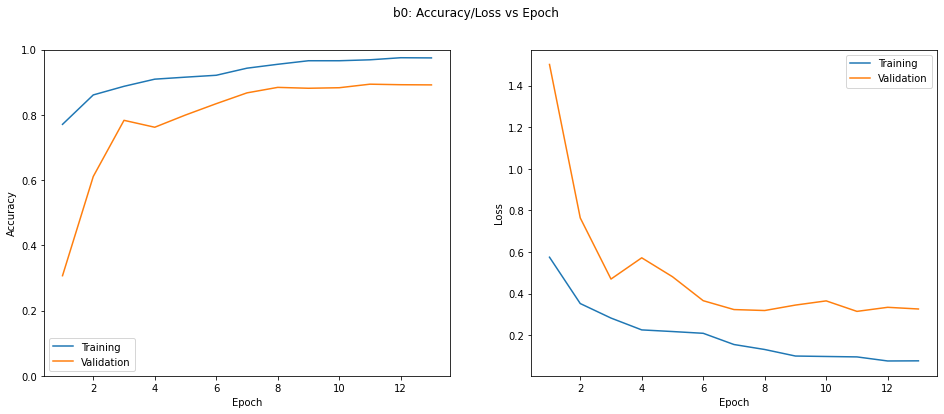

In [ ]:
plot_loss_acc(hist, 'b0')

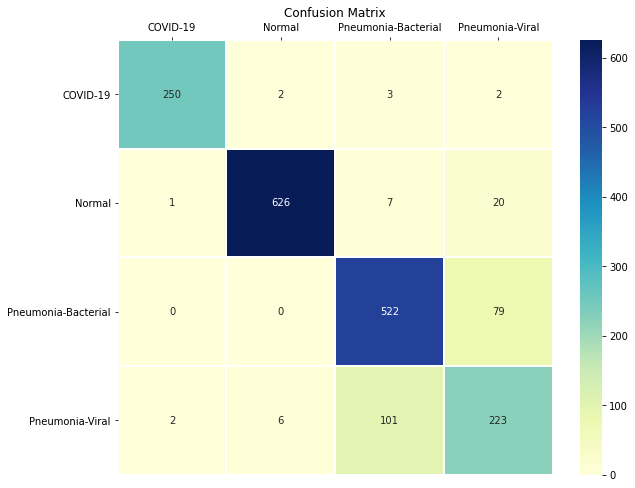

In [ ]:
plot_confusion_matrix(cm)

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/dlproject/weights/efficientnet-b0.pt')

###Focal Loss

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, cls_num_list, beta, gamma):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        per_cls_weights = (1 - beta) / (1 - beta ** torch.tensor(cls_num_list))
        per_cls_weights *= len(cls_num_list) / torch.sum(per_cls_weights)
        self.weight = per_cls_weights.cuda()

    def forward(self, input, target):
        focal_loss = None
        N = input.shape[0]
        probs = torch.softmax(input, dim=1)
        probs_target = probs[range(N), target]
        L = -(1 - probs_target) ** self.gamma * torch.log(probs_target)
        focal_loss = torch.mean(self.weight[target] * L)
        return focal_loss

unique, frequency = np.unique(image_datasets['train'].targets, return_counts=True)
print(unique)
print(frequency)

[0 1 2 3]
[ 768 1962 1800  993]


In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b0')

num_ftrs = model._fc.in_features
last_layers = nn.Sequential(
                            nn.BatchNorm1d(num_features=num_ftrs),
                            nn.Linear(num_ftrs, 64),
                            nn.ReLU(),
                            nn.BatchNorm1d(num_features=64),
                            nn.Dropout(0.5),
                            nn.Linear(64, 4)
                            )
model._fc = last_layers

Loaded pretrained weights for efficientnet-b0


In [ ]:
model.cuda()
criterion = FocalLoss(cls_num_list=list(frequency), beta=0.9999, gamma=2)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
n_epochs = 20
patience = 3
model, hist = train(model, criterion, optimizer, n_epochs, patience, scheduler)
cm = test(model, criterion)

Epoch: 1	loss: 0.243731	accuracy: 0.730943	val_loss: 0.556312	val_accuracy: 0.423140
Validation loss decreased (inf --> 0.556312).  Saving model ...
Epoch: 2	loss: 0.118065	accuracy: 0.817853	val_loss: 0.295698	val_accuracy: 0.604020
Validation loss decreased (0.556312 --> 0.295698).  Saving model ...
Epoch: 3	loss: 0.093639	accuracy: 0.848633	val_loss: 0.202790	val_accuracy: 0.681152
Validation loss decreased (0.295698 --> 0.202790).  Saving model ...
Epoch: 4	loss: 0.083116	accuracy: 0.859316	val_loss: 0.140064	val_accuracy: 0.780011
Validation loss decreased (0.202790 --> 0.140064).  Saving model ...
Epoch: 5	loss: 0.066212	accuracy: 0.884121	val_loss: 0.139720	val_accuracy: 0.757740
Validation loss decreased (0.140064 --> 0.139720).  Saving model ...
Epoch: 6	loss: 0.061709	accuracy: 0.892631	val_loss: 0.109570	val_accuracy: 0.813688
Validation loss decreased (0.139720 --> 0.109570).  Saving model ...
Epoch: 7	loss: 0.058111	accuracy: 0.894441	val_loss: 0.089446	val_accuracy: 0.863

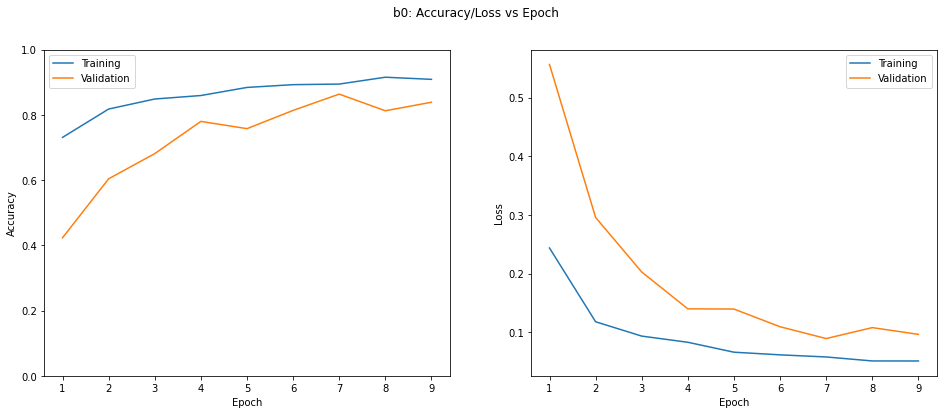

In [ ]:
plot_loss_acc(hist, 'b0')

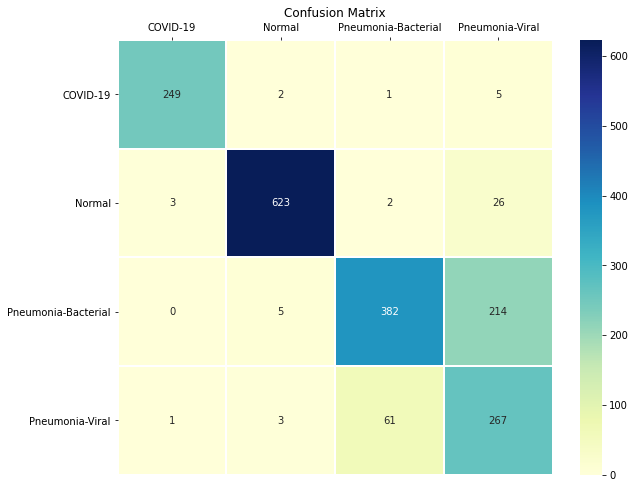

In [ ]:
plot_confusion_matrix(cm)

###Knowledge Distillation

In [ ]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square conv kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 84)  # 53x53 image dimension
        self.fc2 = nn.Linear(84, 4)

    def forward(self, x):
        x = torch.max_pool2d(torch.relu(self.conv1(x)), (2, 2))
        x = torch.max_pool2d(torch.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, int(x.nelement() / x.shape[0]))
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class DistillationLoss(nn.Module):

    def forward(self, student_output, teacher_output, T):
        distill_loss = None
        P = nn.functional.softmax(teacher_output / T, dim=1)
        Q = nn.functional.log_softmax(student_output / T, dim=1)
        distill_loss = nn.KLDivLoss(reduction='batchmean')(Q, P)
        return distill_loss * T**2


def distill(student, teacher, optimizer, n_epochs, patience, alpha, T, scheduler=None):
    hist = {'loss':[], 'acc':[], 'val_loss':[], 'val_acc':[]}
    not_improved = 0
    best_weights = None
    val_loss_min = np.Inf
    
    teacher.eval()
    criterion_student = nn.CrossEntropyLoss()
    criterion_distill = DistillationLoss()

    for epoch in range(n_epochs):
        epoch_stats = []
        for phase in ['train', 'val']:
            if phase == 'train':
                student.train()
            if phase == 'val':
                student.eval()
            losses = 0.0
            corrects = 0
            for data, target in image_loaders[phase]:
                data = data.cuda()
                target = target.cuda()

                out = student(data)
                with torch.no_grad():
                    teacher_output = teacher(data)
                loss_distill = criterion_distill(out, teacher_output, T)
                loss_student = criterion_student(out, target)
                loss = alpha * loss_student + (1 - alpha) * loss_distill

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(out, dim=-1)
                losses += loss.item() * data.size(0)
                corrects += torch.sum(preds==target.data).item()

            if phase == 'train' and scheduler:
                scheduler.step()
            
            epoch_stats += [losses / dataset_sizes[phase],
                            corrects / dataset_sizes[phase]]

        train_loss, train_acc, val_loss, val_acc = epoch_stats
        print('Epoch: {}\tloss: {:.6f}\taccuracy: {:.6f}\tval_loss: {:.6f}\tval_accuracy: {:.6f}'
              .format(epoch+1, train_loss, train_acc, val_loss, val_acc))
        
        if val_loss < val_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                  .format(val_loss_min, val_loss))
            best_weights = copy.deepcopy(student.state_dict())
            val_loss_min = val_loss
            not_improved = 0
        else:
            not_improved += 1
            if not_improved == patience and epoch < n_epochs-1:
                print('Early stopping ...')
                break
        
        student.load_state_dict(best_weights)
        hist['loss'] += [train_loss]
        hist['acc'] += [train_acc]
        hist['val_loss'] += [val_loss]
        hist['val_acc'] += [val_acc]
    return student, hist

In [ ]:
# Train student LeNet without KD
student = LeNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(student.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
n_epochs = 10
patience = 3
student, hist = train(student, criterion, optimizer, n_epochs, patience)
cm = test(student, criterion)

Epoch: 1	loss: 0.834317	accuracy: 0.643491	val_loss: 0.560506	val_accuracy: 0.777838
Validation loss decreased (inf --> 0.560506).  Saving model ...
Epoch: 2	loss: 0.530308	accuracy: 0.779106	val_loss: 0.498438	val_accuracy: 0.790875
Validation loss decreased (0.560506 --> 0.498438).  Saving model ...
Epoch: 3	loss: 0.479197	accuracy: 0.799203	val_loss: 0.463288	val_accuracy: 0.801195
Validation loss decreased (0.498438 --> 0.463288).  Saving model ...
Epoch: 4	loss: 0.451633	accuracy: 0.808619	val_loss: 0.462012	val_accuracy: 0.799565
Validation loss decreased (0.463288 --> 0.462012).  Saving model ...
Epoch: 5	loss: 0.421786	accuracy: 0.820931	val_loss: 0.483870	val_accuracy: 0.789245
Epoch: 6	loss: 0.420455	accuracy: 0.822198	val_loss: 0.444176	val_accuracy: 0.816947
Validation loss decreased (0.462012 --> 0.444176).  Saving model ...
Epoch: 7	loss: 0.422102	accuracy: 0.819120	val_loss: 0.432438	val_accuracy: 0.823466
Validation loss decreased (0.444176 --> 0.432438).  Saving model 

In [ ]:
# Load trained teacher B0
model = EfficientNet.from_pretrained('efficientnet-b0')

num_ftrs = model._fc.in_features
last_layers = nn.Sequential(
                            nn.BatchNorm1d(num_features=num_ftrs),
                            nn.Linear(num_ftrs, 64),
                            nn.ReLU(),
                            nn.BatchNorm1d(num_features=64),
                            nn.Dropout(0.5),
                            nn.Linear(64, 4)
                            )
model._fc = last_layers

model.load_state_dict(torch.load('/content/drive/MyDrive/dlproject/weights/efficientnet-b0.pt'))
model.cuda()
model.eval()

Loaded pretrained weights for efficientnet-b0


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [ ]:
# Train student with KD
student = LeNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(student.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
n_epochs = 10
patience = 3
alpha = 0.1
T = 3
student, hist = distill(student, model, optimizer, n_epochs, patience, alpha, T)
cm = test(student, criterion)

Epoch: 1	loss: 3.339912	accuracy: 0.657976	val_loss: 1.631495	val_accuracy: 0.774036
Validation loss decreased (inf --> 1.631495).  Saving model ...
Epoch: 2	loss: 1.816740	accuracy: 0.795582	val_loss: 1.275203	val_accuracy: 0.800109
Validation loss decreased (1.631495 --> 1.275203).  Saving model ...
Epoch: 3	loss: 1.593817	accuracy: 0.817853	val_loss: 1.281473	val_accuracy: 0.803911
Epoch: 4	loss: 1.607777	accuracy: 0.805722	val_loss: 1.251938	val_accuracy: 0.808800
Validation loss decreased (1.275203 --> 1.251938).  Saving model ...
Epoch: 5	loss: 1.451402	accuracy: 0.827087	val_loss: 1.270672	val_accuracy: 0.814775
Epoch: 6	loss: 1.486672	accuracy: 0.823466	val_loss: 1.029973	val_accuracy: 0.834872
Validation loss decreased (1.251938 --> 1.029973).  Saving model ...
Epoch: 7	loss: 1.381795	accuracy: 0.832156	val_loss: 1.113826	val_accuracy: 0.820206
Epoch: 8	loss: 1.292518	accuracy: 0.845374	val_loss: 1.166947	val_accuracy: 0.816947
Epoch: 9	loss: 1.319986	accuracy: 0.841391	val_lo